<a href="https://colab.research.google.com/github/yogeshtak/Machine_Learning/blob/master/dog_vision_deep_learning/dog_vision_multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook we build an end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifying breed of the dog by just showing a picture.
## 2. Data
Kaggle: https://www.kaggle.com/c/dog-breed-identification 

## 3. Evaluation
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation 
## 4. Features

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning
* There are 120 different dog classes.
* There are around 10,000+ images in the training set. (these images have label)
* There are around 10,000+ images in the test set. (label absent, we'll predict them)



In [1]:
#unzip the data in the google drive
#!unzip "/content/drive/MyDrive/Projects/dog-vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Projects/dog-vision/"

# Get our workspace Ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using GPU

In [1]:
#import tensorflow into colab
import tensorflow as tf
print("TF version", tf.__version__)

TF version 2.5.0


In [2]:
import tensorflow_hub as hub
print("TF Hub Version", hub.__version__)

TF Hub Version 0.12.0


In [3]:
#check for GPU availability 
print("GPU", "available (YESSS!!!)") if tf.config.list_physical_devices("GPU") else "not available :("

GPU available (YESSS!!!)


## 2. Getting our data ready (turning data into tensors)

With all ML models, our data need to be in numerical format. Turning images into tensors (numericao representatation)

In [5]:
#checkout the labels
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Projects/dog-vision/labels.csv")

In [6]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6fd91d9b93604a4b156662fb1d763d29  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
#how many images are there for each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

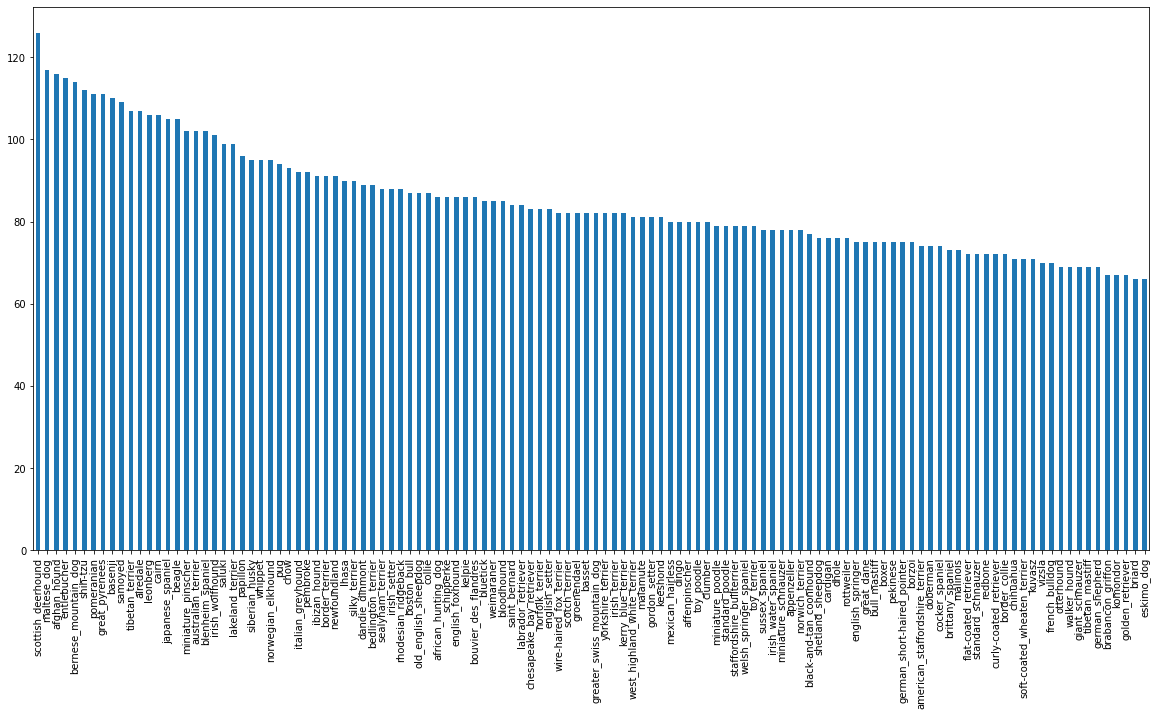

In [10]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [12]:
labels_csv["breed"].value_counts().median()

82.0

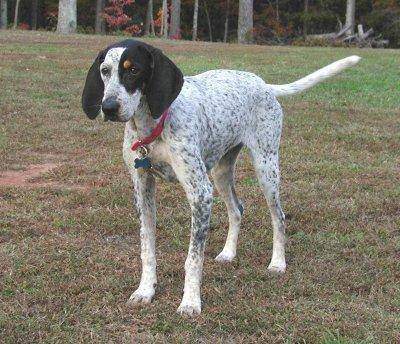

In [14]:
#view one sample image
from IPython.display import Image
Image("/content/drive/MyDrive/Projects/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels
Let's get a list of all images file pathnames.

In [15]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [17]:
#creating pathname from Image list
filenames = ["/content/drive/MyDrive/Projects/dog-vision/train/"+fname+".jpg" for fname in labels_csv["id"]]

#checking
filenames[:5]

['/content/drive/MyDrive/Projects/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

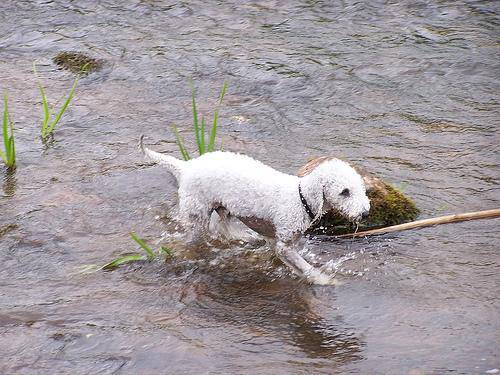

In [18]:
Image(filenames[5])

In [19]:
#check whether number of filenames matches number of actual image files
import os

if len(os.listdir("/content/drive/MyDrive/Projects/dog-vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!! Go ahead.")
else:
  print("filenames do not match actual amount of files. Check the target directory.")

Filenames match actual amount of files!! Go ahead.


Since we have got our training image filepaths in a list, let's prepare our labels

In [20]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) does same thing
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [21]:
len(labels)

10222

In [22]:
#check if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Labels matches with filename, Nothing is missing")
else:
  print("Number of labels does not match")

Labels matches with filename, Nothing is missing


In [23]:
#file unique labels
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [24]:
len(unique_breeds)

120

In [25]:
#Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [28]:
#Turn every label intp a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [29]:
len(boolean_labels)

10222

In [30]:
#example turning boolean array into integers
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) #index where the label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [31]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## creating our own validation set


In [32]:
#setup X and y
X = filenames
y = boolean_labels

In [33]:
len(filenames)

10222

We'll start with 1000 images and increase as needed

In [35]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000, max:10000}

In [36]:
#lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size = 0.2,
                                                      random_state = 42)

len(X_train), len(y_train), len(X_valid), len(y_valid)

(800, 800, 200, 200)

In [37]:
X_train[:5]

['/content/drive/MyDrive/Projects/dog-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
 '/content/drive/MyDrive/Projects/dog-vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg']

In [38]:
y_train[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (244,244)
5. Return the modified `image`

**Before we do, let's see what importing an image looks like**

In [40]:
#convert an image to NumPy array
from matplotlib.pyplot import imread
image =imread(filenames[42])
image.shape

(257, 350, 3)

In [41]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [49]:
image.max()

255

In [50]:
image.min()

0

In [51]:
#converts into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

tensor and numpy image imread looks same. tensor just runs on GPU

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalise our image for faster processing
5. Resize the `image` to be a shape of (244,244)
6. Return the modified `image`


In [52]:
#define image size
IMG_SIZE = 224

#create a function for preprocessing images
def process_image(image_path, image_size = IMG_SIZE):
  """
  Takes an image path and turn the image into tensor
  """

  #read in an image file
  image = tf.io.read_file(image_path)

  #turn the jpg into numerical tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)

  #convert the color channel values from 0-255 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32) #this normalisation, we do for make processing faster

  #Resize the image to our desired value (244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go.. they all might not fit into memory.

So, that's why we do 32 images (batch size) at a time. You can adjust if you want.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image,label)`

In [53]:
#create a simple function to return tuples (image, label)
def get_image_label(image_path, label):
  """
  Takes image file path name and the associated label,
  processes the image and returns a tuple of (image,label)
  """
  image = process_image(image_path)
  return image,label

In [54]:
#demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)` let's make a function to turn all our data (`X` & `y`) into batches

In [55]:
#define the batch size, 32 is a good start
BATCH_SIZE = 32

#create a function to turn data into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data =False, test_data = False):
  """
  Create batches out of data out of (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """

  #if the data is a test dataset, we probably don't have labels

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepath (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
                                              
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data_batches...")
    #turn filepaths and labels to tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    #shuffling pathnames and labels before mapping image processor function
    #shuffling filenames is faster than shuufling images
    data = data.shuffle(buffer_size=len(X))
    #creates (image,label) tuples, also turns image path into preprocessed images
    data = data.map(get_image_label)

    #turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch



In [56]:
#create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data_batches...
Creating validation data batches...


In [57]:
#checkout different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))